Train shape: (20758, 18)
Test shape: (13840, 17)


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


C:\Users\filip\AppData\Local\Temp\ipykernel_22392\1525459651.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'yes': True, 'no': False}, inplace=True)


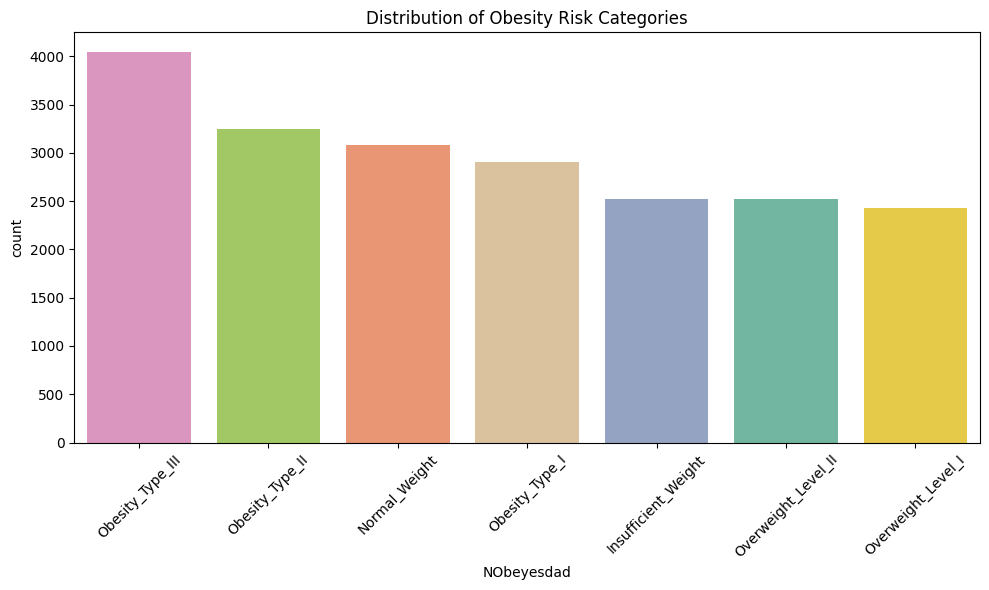

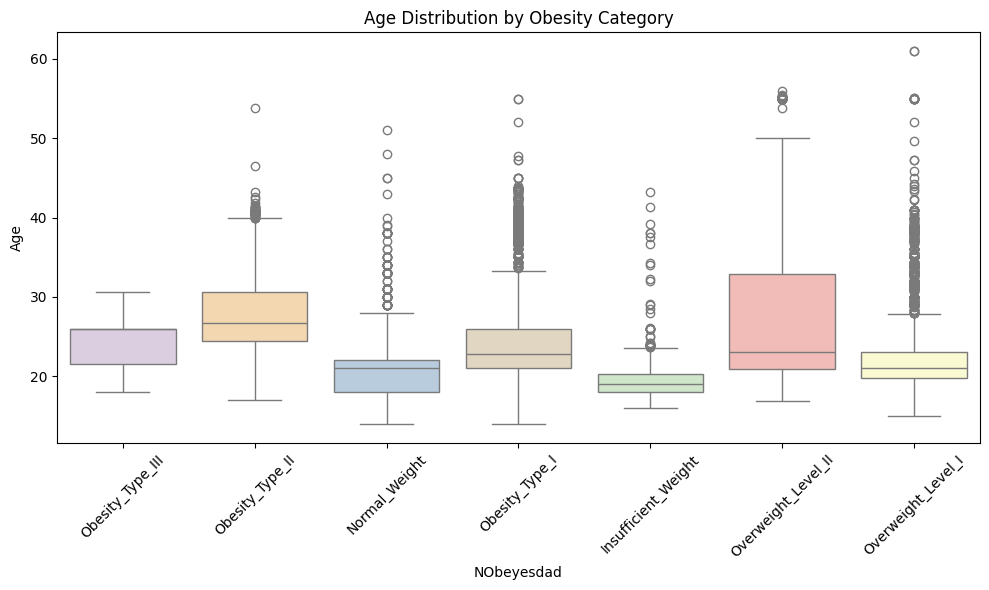

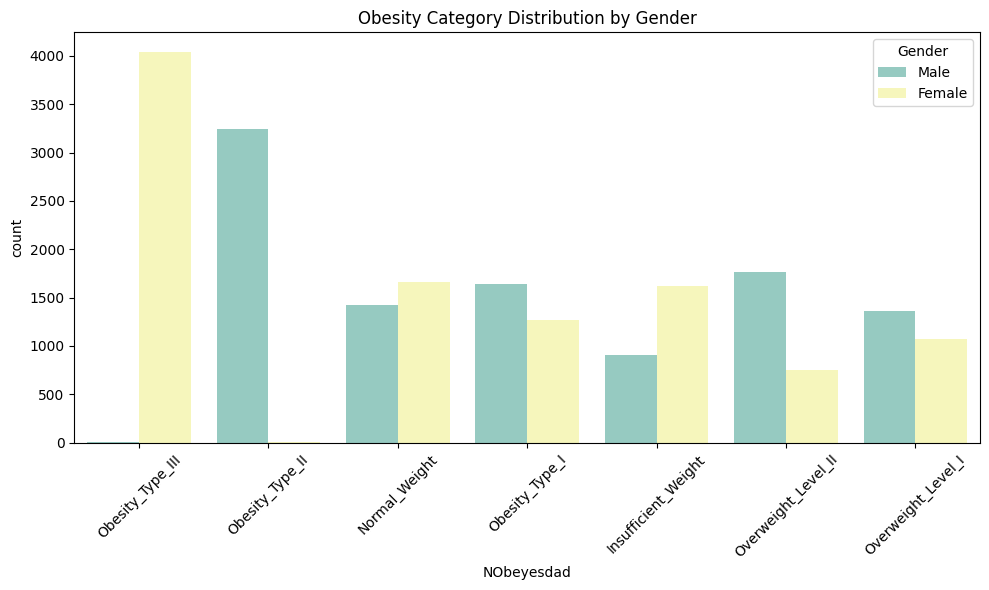

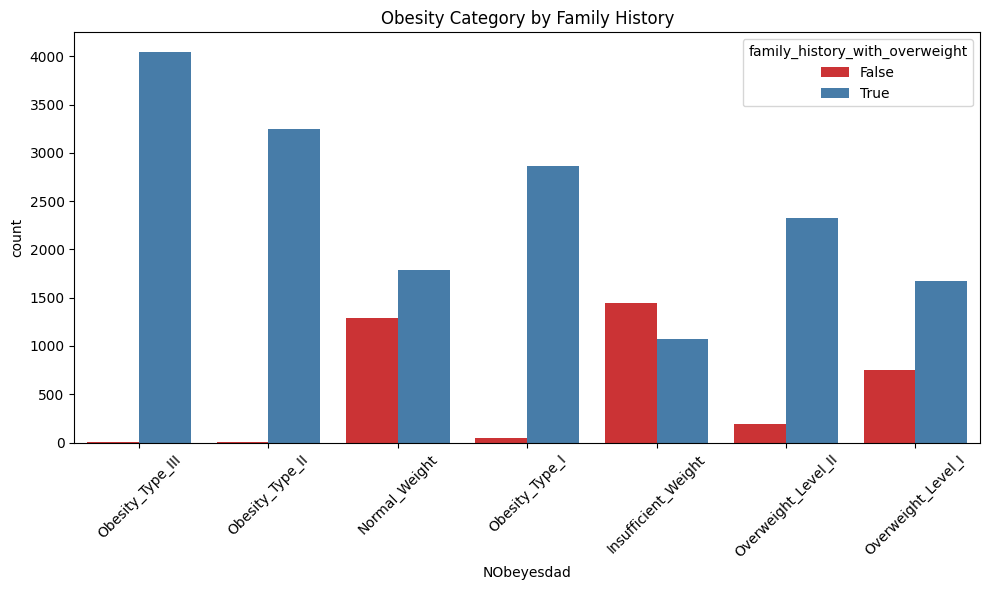

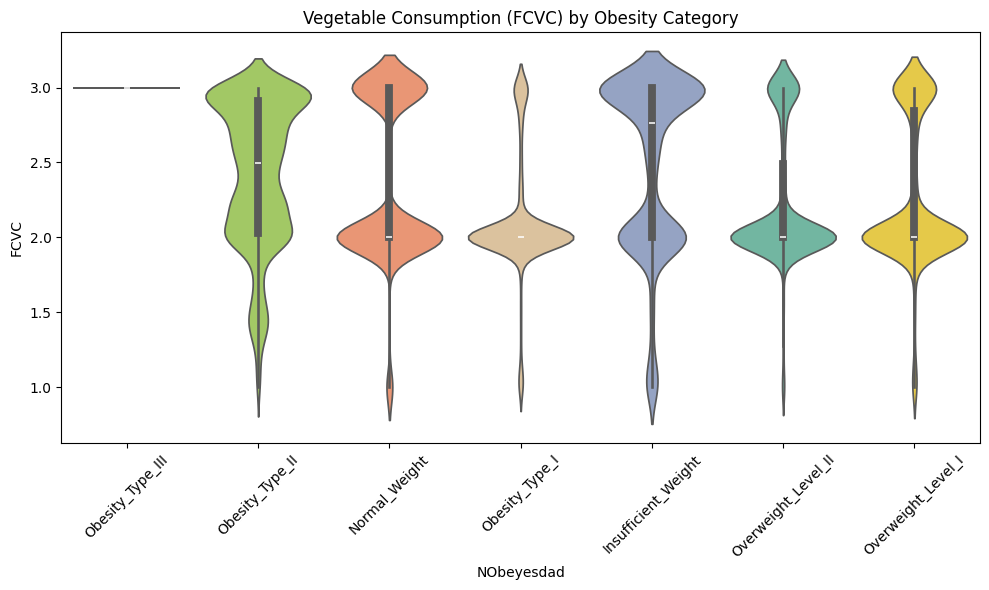

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       524
           1       0.88      0.89      0.89       626
           2       0.79      0.79      0.79       484
           3       0.79      0.81      0.80       514
           4       0.89      0.87      0.88       543
           5       0.98      0.97      0.97       657
           6       1.00      1.00      1.00       804

    accuracy                           0.91      4152
   macro avg       0.90      0.90      0.90      4152
weighted avg       0.91      0.91      0.91      4152


Sample predictions:
      id Predicted_Obesity_Level
0  20758         Obesity_Type_II
1  20759      Overweight_Level_I
2  20760        Obesity_Type_III
3  20761          Obesity_Type_I
4  20762        Obesity_Type_

In [1]:
# 📘 Obesity Prediction - Kaggle Playground S4E2

# === Imports ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from xgboost import XGBClassifier

# === 1. Load data ===
train_df = pd.read_csv("DatiCsv/train.csv")
test_df = pd.read_csv("DatiCsv/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
display(train_df.head())

# === 2. Data cleaning ===
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

for df in [train_df, test_df]:
    df.replace({'yes': True, 'no': False}, inplace=True)
    df[:] = df.infer_objects(copy=False)


# === 3. Exploratory Data Analysis before encoding ===
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='NObeyesdad', hue='NObeyesdad',
              order=train_df['NObeyesdad'].value_counts().index,
              palette='Set2', legend=False)
plt.title('Distribution of Obesity Risk Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='NObeyesdad', y='Age', hue='NObeyesdad',
            order=train_df['NObeyesdad'].value_counts().index,
            palette='Pastel1', legend=False)
plt.title('Age Distribution by Obesity Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='NObeyesdad', hue='Gender',
              order=train_df['NObeyesdad'].value_counts().index,
              palette='Set3')
plt.title('Obesity Category Distribution by Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='NObeyesdad', hue='family_history_with_overweight',
              order=train_df['NObeyesdad'].value_counts().index,
              palette='Set1')
plt.title('Obesity Category by Family History')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(data=train_df, x='NObeyesdad', y='FCVC', hue='NObeyesdad',
               order=train_df['NObeyesdad'].value_counts().index,
               palette='Set2', legend=False)
plt.title('Vegetable Consumption (FCVC) by Obesity Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# === 4. Encode target labels ===
weight_map = {
    'Normal_Weight': 1,
    'Insufficient_Weight': 0,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}
train_df['NObeyesdad'] = train_df['NObeyesdad'].map(weight_map).astype(int)

# === 4. Encoding delle colonne categoriche (esclusa la colonna target) ===
categorical_cols = train_df.select_dtypes(include='object').columns

label_encoders = {}
common_categorical_cols = [col for col in categorical_cols if col in test_df.columns]
le = LabelEncoder()
for col in common_categorical_cols:
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    test_df[col] = test_df[col].astype(str)
    test_df[col] = test_df[col].apply(lambda x: x if x in le.classes_ else 'unknown')
    le.classes_ = np.append(le.classes_, 'unknown') if 'unknown' not in le.classes_ else le.classes_
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le
    

# === 5. Feature Engineering ===
for df in [train_df, test_df]:
    # 1. Activity Index (FAF - TUE)
    activity_index_raw = df['FAF'] - df['TUE']  # Calcolo grezzo
    df['ActivityIndex'] = pd.cut(activity_index_raw,
                                 bins=[-np.inf, 0.3, 1.0, np.inf],
                                 labels=[1, 2, 3]).astype("Int64")

    # 2. Healthy Diet Score (FCVC - CAEC)
    healthy_diet_score_raw = df['FCVC'] - df['CAEC']  # Calcolo grezzo
    df['HealthyDietScore'] = pd.cut(healthy_diet_score_raw,
                                    bins=[-np.inf, -0.5, 1.0, np.inf],
                                    labels=[1, 2, 3]).astype("Int64")

    # 3. Overeating Score (CH2O + NCP - FCVC)
    overeating_score_raw = df['CH2O'] + df['NCP'] - df['FCVC']  # Calcolo grezzo
    df['OvereatingScore'] = pd.cut(overeating_score_raw,
                                   bins=[-np.inf, 2.5, 4.0, np.inf],
                                   labels=[1, 2, 3]).astype("Int64")


# === 7. Train/Validation Split ===
X = train_df.drop(columns=['id', 'NObeyesdad'])
y = train_df['NObeyesdad']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# === 8. Feature Scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_test = test_df.drop(columns=['id', 'NObeyesdad'], errors='ignore').copy()
X_test.fillna(0, inplace=True)
X_test_scaled = scaler.transform(X_test)

# === 9. Modeling with XGBoost ===
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)
 
best_model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

# === 10. Validation Evaluation ===
y_pred = best_model.predict(X_val_scaled)
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred))

# === 11. Predictions on Test Set ===
predictions = best_model.predict(X_test_scaled)
predictions = np.clip(predictions, 0, 6)
inverse_map = {v: k for k, v in weight_map.items()}
pred_labels = [inverse_map.get(p, 'Unknown') for p in predictions]

output = test_df[['id']].copy()
output['Predicted_Obesity_Level'] = pred_labels
output.to_csv("predizioni_obesita.csv", index=False)

print("\nSample predictions:")
print(output.head(10))

In [2]:
train_df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,...,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,ActivityIndex,HealthyDietScore,OvereatingScore
0,0,1,24.443011,1.699998,81.669950,True,True,2.000000,2.983297,3,...,2.763573,False,0.000000,0.976473,2,3,3,1,1,2
1,1,0,18.000000,1.560000,57.000000,True,True,2.000000,3.000000,2,...,2.000000,False,1.000000,1.000000,0,0,1,1,2,2
2,2,0,18.000000,1.711460,50.165754,True,True,1.880534,1.411685,3,...,1.910378,False,0.866045,1.673584,0,3,0,1,1,1
3,3,0,20.952737,1.710730,131.274851,True,True,3.000000,3.000000,3,...,1.674061,False,1.467863,0.780199,2,3,6,2,2,1
4,4,1,31.641081,1.914186,93.798055,True,True,2.679664,1.971472,3,...,1.979848,False,1.967973,0.931721,2,3,3,3,2,1


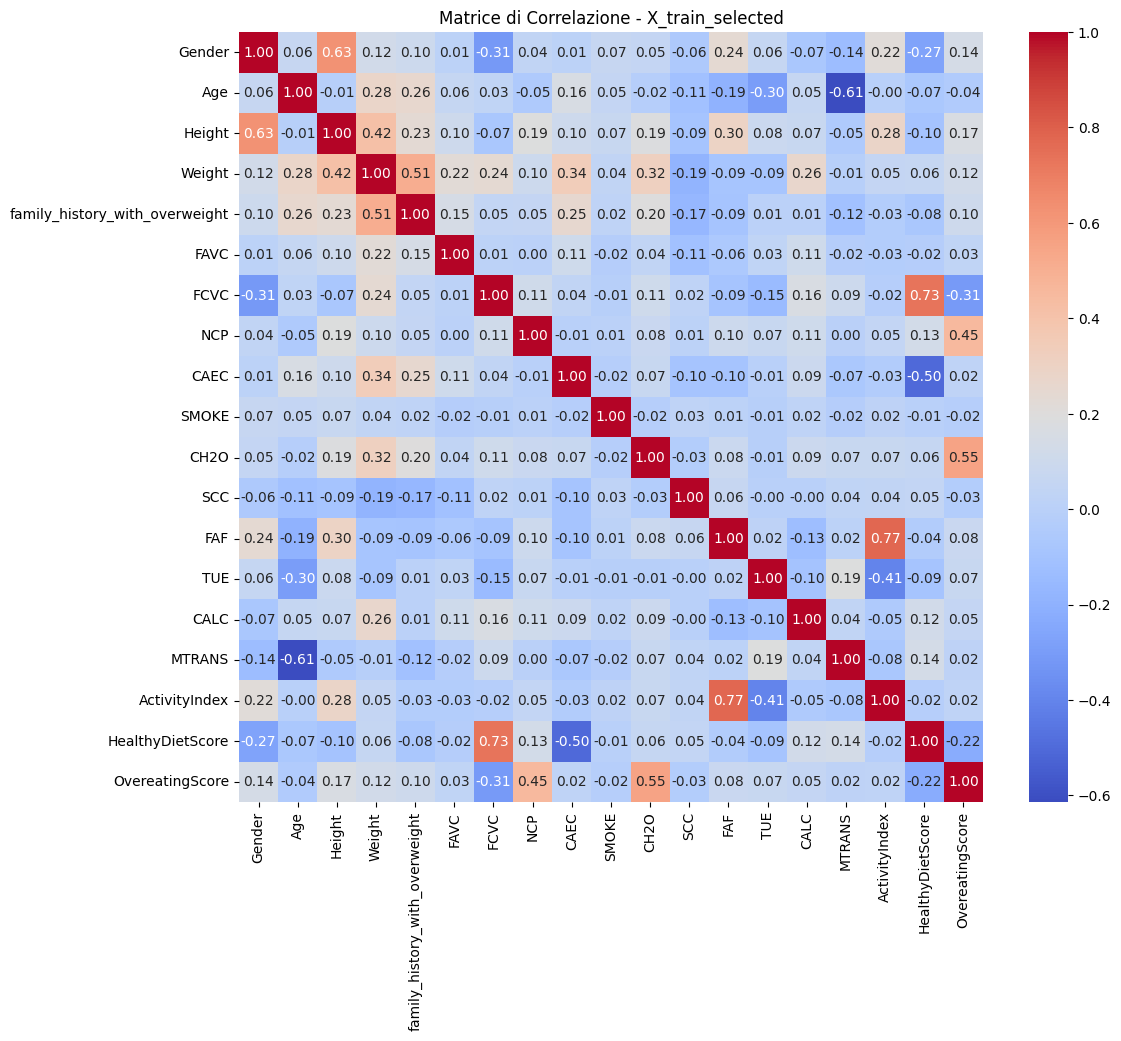

In [3]:
# === Correlation matrix ===
X_train_selected = X_train.copy()
correlation_matrix = X_train_selected.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Heatmap title
plt.title("Matrice di Correlazione - X_train_selected")
plt.show()